In [1]:
import os
import csv
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import time
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
import dash
from dash import dcc, html
import calendar
from dash.dependencies import Input, Output
from datetime import datetime
import folium

In [2]:
fahrzeiten_filenames = [filename for filename in os.listdir('../raw_data/fahrzeiten/') if filename.endswith('.csv')]
fahrzeiten_head = pd.read_csv('../raw_data/fahrzeiten/' + fahrzeiten_filenames[0], nrows=0).columns

def get_fahrzeiten_dask_df(filename, columns=None):
    if columns is None:
        columns = fahrzeiten_head
    df = dd.read_csv('../raw_data/fahrzeiten/' + filename, usecols=columns)
    return df.compute()

fahrzeiten_dfs = {filename: get_fahrzeiten_dask_df(filename) for filename in fahrzeiten_filenames}

# Function to get the data from the csv files and return a dataframe
def csv_to_df(filepath):
    try:
        return pd.read_csv(filepath, sep=',')
    except pd.errors.ParserError:
        return pd.read_csv(filepath, sep=';')

passagierfrequenz_df = csv_to_df('../raw_data/passagierfrequenz.csv')
haltestelle_df = csv_to_df('../raw_data/haltestelle.csv')
haltepunkt_df = csv_to_df('../raw_data/haltepunkt.csv')

# TODO:
- Toggle implementieren um NICHT zu suchen
- Describe als Button

In [3]:
"""
This function displays a UI for exploring CSV files in the '../raw_data/fahrzeiten' directory.
It provides a dropdown to select a file, and 'Head', 'Previous', 'Next', and 'Tail' buttons to navigate through the data.
The data is displayed in a DataFrame format, showing 10 rows at a time.
"""
def show_all_fahrzeiten_csvs():
    start = 0
    df = None

    # Create UI elements
    head_button = widgets.Button(description='Head')
    prev_button = widgets.Button(description='Previous')
    next_button = widgets.Button(description='Next')
    tail_button = widgets.Button(description='Tail')
    output = widgets.Output()
    column_dropdown = widgets.Dropdown(options=df.columns if df is not None else [])
    search_input = widgets.Text(value='', placeholder='Type something', description='Search:', disabled=False)
    search_button = widgets.Button(description='Search')
    dimensions_label = widgets.Label()

    # Function to load CSV file into DataFrame
    def show_csv(button_instance=None):
        nonlocal start, df
        start = 0
        df = fahrzeiten_dfs[filenames[dropdown.value]]
        column_dropdown.options = df.columns
        show_output()

    # Event handlers for button clicks
    def on_head_button_clicked(b):
        nonlocal start
        start = 0
        show_output()

    def on_prev_button_clicked(b):
        nonlocal start
        start = max(0, start-10)
        show_output()

    def on_next_button_clicked(b):
        nonlocal start
        start = min(len(df)-10, start+10)
        show_output()

    def on_tail_button_clicked(b):
        nonlocal start
        start = len(df)-10
        show_output()

    # Function to display DataFrame in output widget
    def show_output():
        with output:
            output.clear_output()
            display(HTML('<div style="overflow-x: auto; white-space: nowrap;">' 
                        + df.iloc[start:start+10].to_html() + '</div>'))
            # Update the dimensions label
            dimensions_label.value = f'Dimensions: {df.shape}'
    
    # Function to handle search
    def handle_search(button_instance=None):
        nonlocal df
        if search_input.value:
            df = df[df[column_dropdown.value].astype(str).str.contains(search_input.value)]
        show_output()

    # Get list of CSV files
    filenames = {f'{filename[26:28]}.{filename[24:26]}.{filename[20:24]} bis {filename[35:37]}.{filename[33:35]}.{filename[29:33]}': filename for filename in fahrzeiten_filenames}
    
    # Create dropdown and show button
    dropdown = widgets.Dropdown(options=list(filenames.keys()))
    show_button = widgets.Button(description='Show')

    # Display UI elements
    title = widgets.HTML('<h2 style="text-align: center;">Fahrzeiten: SOLL und IST</h2>')
    box_layout = widgets.Layout(display='flex', justify_content='center')
    display(
        widgets.VBox(
            [
                title, widgets.HBox([dropdown, show_button], layout=box_layout),
                widgets.HBox([column_dropdown, search_input, search_button], layout=box_layout),
                output,
                widgets.HBox([dimensions_label], layout=widgets.Layout(justify_content='flex-start')),
                widgets.HBox([head_button, prev_button, next_button, tail_button], layout=box_layout)
            ],
            layout=box_layout
        )
    )
    
    # Attach event handlers to buttons
    show_button.on_click(show_csv)
    head_button.on_click(on_head_button_clicked)
    prev_button.on_click(on_prev_button_clicked)
    next_button.on_click(on_next_button_clicked)
    tail_button.on_click(on_tail_button_clicked)
    search_button.on_click(handle_search)

In [4]:
show_all_fahrzeiten_csvs()

In [5]:
"""
This function provides a user interface for exploring CSV files in the '../raw_data' directory.
The user can navigate through the data using 'Head', 'Previous', 'Next', and 'Tail' buttons, which display the data in chunks of 10 rows at a time.
"""
def show_other_csvs():
    start = 0
    df = None

    # Create UI elements
    head_button = widgets.Button(description='Head')
    prev_button = widgets.Button(description='Previous')
    next_button = widgets.Button(description='Next')
    tail_button = widgets.Button(description='Tail')
    output = widgets.Output()
    column_dropdown = widgets.Dropdown(options=df.columns if df is not None else [])
    search_input = widgets.Text(value='', placeholder='Type something', description='Search:', disabled=False)
    search_button = widgets.Button(description='Search')
    dimensions_label = widgets.Label()

    # Function to load CSV file into DataFrame
    def show_csv(button_instance=None):
        nonlocal start, df
        start = 0
        df = csv_to_df('../raw_data/' + dropdown.value)
        column_dropdown.options = df.columns  # Update column options
        show_output()

    # Event handlers for button clicks
    def on_head_button_clicked(b):
        nonlocal start
        start = 0
        show_output()

    def on_prev_button_clicked(b):
        nonlocal start
        start = max(0, start-10)
        show_output()

    def on_next_button_clicked(b):
        nonlocal start
        start = min(len(df)-10, start+10)
        show_output()

    def on_tail_button_clicked(b):
        nonlocal start
        start = len(df)-10
        show_output()

    # Function to display DataFrame in output widget
    def show_output():
        with output:
            output.clear_output()
            display(HTML('<div style="overflow-x: auto; white-space: nowrap;">' 
                        + df.iloc[start:start+10].to_html() + '</div>'))
            # Update the dimensions label
            dimensions_label.value = f'Dimensions: {df.shape}'

    # Function to handle search
    def handle_search(button_instance=None):
        nonlocal df
        if search_input.value:
            df = df[df[column_dropdown.value].astype(str).str.contains(search_input.value)]
        show_output()

    # Get list of CSV files
    filenames = [filename for filename in os.listdir('../raw_data') if filename.endswith('.csv')]
    
    # Create dropdown and show button
    dropdown = widgets.Dropdown(options=filenames)
    show_button = widgets.Button(description='Show')

    # Display UI elements
    title = widgets.HTML('<h2 style="text-align: center;">Other CSVs</h2>')
    box_layout = widgets.Layout(display='flex', justify_content='center')
    display(
        widgets.VBox(
            [
                title, widgets.HBox([dropdown, show_button], layout=box_layout),
                widgets.HBox([column_dropdown, search_input, search_button], layout=box_layout),
                output,
                widgets.HBox([dimensions_label], layout=widgets.Layout(justify_content='flex-start')),
                widgets.HBox([head_button, prev_button, next_button, tail_button], layout=box_layout)
            ],
            layout=box_layout
        )
    )
    
    # Attach event handlers to buttons
    show_button.on_click(show_csv)
    head_button.on_click(on_head_button_clicked)
    prev_button.on_click(on_prev_button_clicked)
    next_button.on_click(on_next_button_clicked)
    tail_button.on_click(on_tail_button_clicked)
    search_button.on_click(handle_search)

In [6]:
show_other_csvs()

In [7]:
def create_bar_chart_empty_cells_percentage(df, save=False, df_name='placeholder'):
    empty_cells_percentages = {column: (sum_val := df[column].replace('', np.nan).isnull().sum(), sum_val / len(df)) for column in df.columns}

    # Convert the dictionary to a DataFrame for easier plotting
    df_empty_cells = pd.DataFrame(empty_cells_percentages, index=['Empty Cells', 'Percentage']).T
    df_empty_cells = df_empty_cells.sort_values('Percentage', ascending=True)

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df_empty_cells['Percentage'] * 100, y=df_empty_cells.index)
    plt.title(f'Percentage of Empty Cells in Each Column')
    plt.xlabel('Percentage (%)')

    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 101, 5))

    # Display the number of empty cells next to the bars
    for i, (num, perc) in enumerate(zip(df_empty_cells['Empty Cells'], df_empty_cells['Percentage'] * 100)):
        if num > 0:
            plt.text(perc, i, int(num), va='center')

    if save:
        plt.savefig(f'../figures/exploration/empty_cells_percentage_{df_name}.png', bbox_inches='tight')
        plt.close()

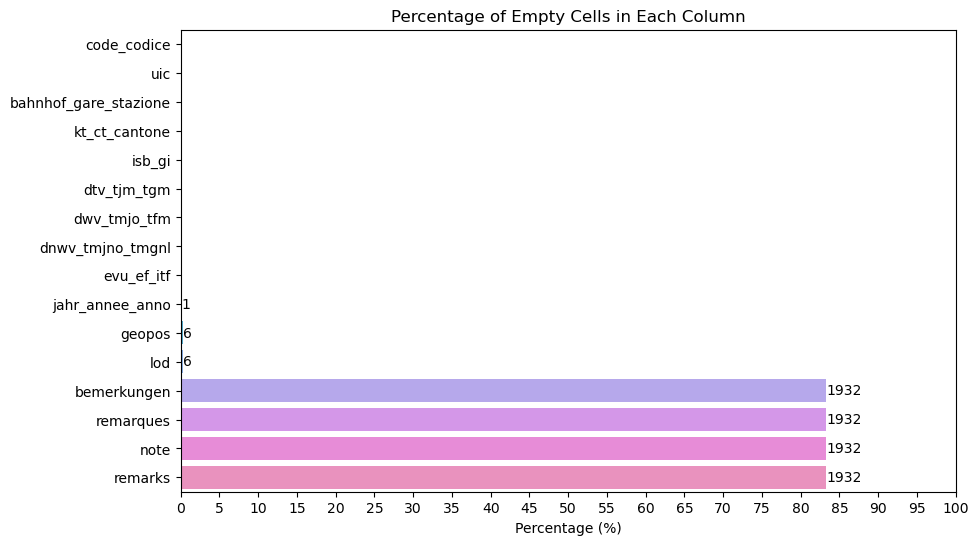

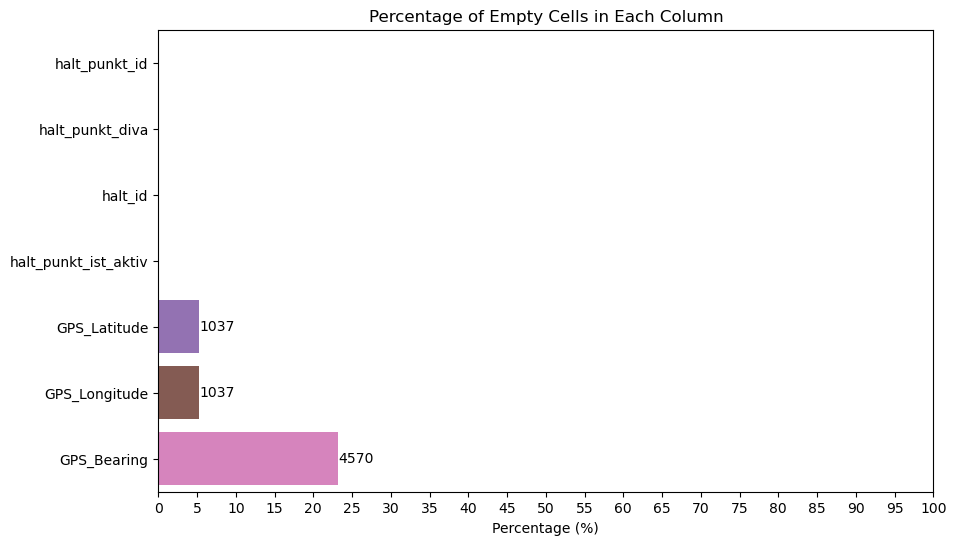

In [9]:
create_bar_chart_empty_cells_percentage(passagierfrequenz_df, save=True, df_name='passagierfrequenz')
create_bar_chart_empty_cells_percentage(haltepunkt_df, save=True, df_name='haltepunkt')

In [11]:
# Wie viele Einzigartige Bahnen (linie) gibt es in den fahrzeiten_dfs
unique_linien = set()
for df in fahrzeiten_dfs.values():
    unique_linien.update(df['linie'].unique())
print(f'Unique Linien: {len(unique_linien)}')
print(unique_linien)

Unique Linien: 73
{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 910, 912, 17, 916, 918, 919, 412, 31, 32, 33, 162, 35, 163, 37, 38, 165, 40, 161, 301, 46, 302, 303, 305, 306, 304, 308, 309, 307, 311, 184, 185, 314, 61, 62, 701, 64, 704, 66, 67, 703, 69, 70, 325, 72, 705, 75, 76, 77, 78, 79, 80, 83, 89, 91, 94, 743, 744, 745, 751}


In [12]:
# Wie oft ist eine Linie in den fahrzeiten_dfs vorhanden
def create_bar_chart_linien_counts(save=False, values=10):
    linien_counts = {}

    for df in fahrzeiten_dfs.values():
        size = df.groupby('linie').size()
        for linie, count in size.items():
            if linie in linien_counts:
                linien_counts[linie] += count
            else:
                linien_counts[linie] = count
                
    df_linien_counts = pd.DataFrame(linien_counts.items(), columns=['Line', 'Count'])
    
    if values > df_linien_counts.shape[0]:
        values = df_linien_counts.shape[0]
    
    df_linien_counts = df_linien_counts.sort_values('Count', ascending=False).head(values)

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=df_linien_counts['Line'], y=df_linien_counts['Count'], order=df_linien_counts['Line'], ax=ax)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
    plt.title(f'Top {values} Most Frequent Lines in Fahrzeiten CSVs')
    plt.xlabel('Line')
    plt.ylabel('Count')
    plt.grid(axis='y')
    
    if save:
        plt.savefig('../figures/exploration/linien_count.png', bbox_inches='tight')
        plt.close()

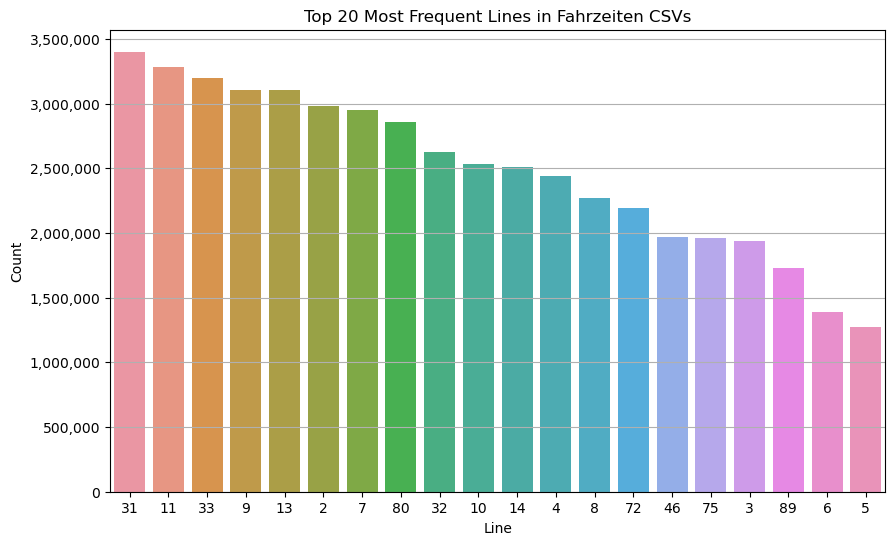

In [17]:
create_bar_chart_linien_counts(save=True, values=20)

In [12]:
# Wie viele Haltestellen gibt es?
print(f'Unique Haltestellen: {len(haltestelle_df["halt_diva"].unique())}')

Unique Haltestellen: 769


In [18]:
# Wie oft ist eine Haltestelle in den fahrzeiten_dfs vorhanden
def create_bar_chart_haltestellen_counts(save=False, values=10):
    haltestellen_counts = {}

    for df in fahrzeiten_dfs.values():
        size = df.groupby('halt_diva_von').size()
        for halt, count in size.items():
            haltestellen_name = haltestelle_df[haltestelle_df['halt_diva'] == halt]['halt_lang'].values[0]
            if halt in haltestellen_counts:
                haltestellen_counts[haltestellen_name] += count
            else:
                haltestellen_counts[haltestellen_name] = count
                
    df_haltestellen_counts = pd.DataFrame(haltestellen_counts.items(), columns=['Haltestelle', 'Count'])
    df_haltestellen_counts = df_haltestellen_counts.sort_values('Count', ascending=False).head(values)

    # Create the horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=df_haltestellen_counts['Count'], y=df_haltestellen_counts['Haltestelle'], order=df_haltestellen_counts['Haltestelle'], ax=ax)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
    plt.title(f'Top {values} meist vorkommende Haltestellen in Fahrzeiten CSVs')
    plt.xlabel('Anzahl')
    plt.ylabel('Haltestelle')
    plt.grid(axis='x')
    plt.xticks(np.arange(0, 15000, 1000))
    
    if save:
        plt.savefig('../figures/exploration/haltestellen_count.png', bbox_inches='tight')
        plt.close()

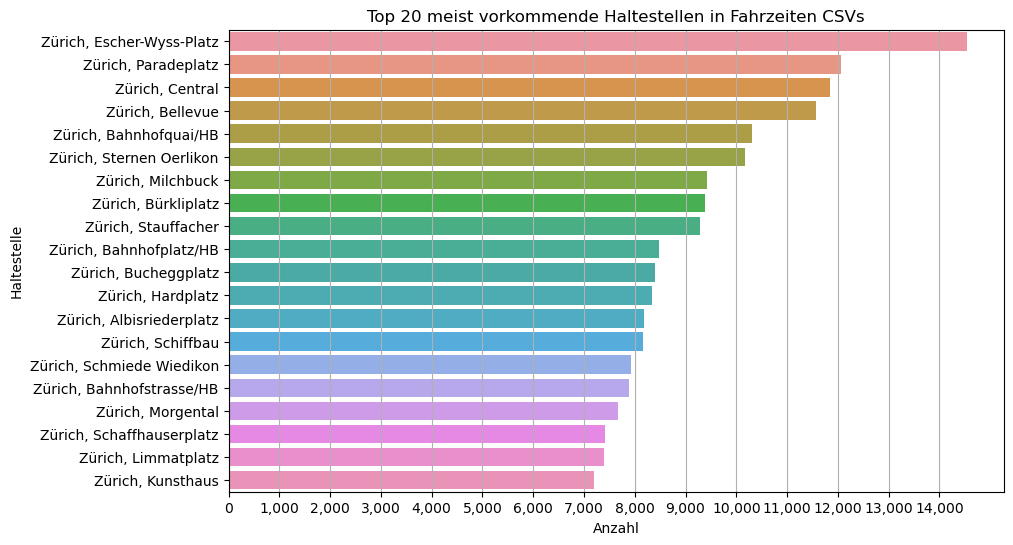

In [20]:
create_bar_chart_haltestellen_counts(save=True, values=20)

# TODO:
- Halt_diva_nach?
- Wie viele Haltestellen gibt es pro Stadt?

In [27]:
# Wie viele Städte gibt es in den fahrzeiten_dfs
unique_staedte = set()
for df in fahrzeiten_dfs.values():
    halt_diva = df['halt_diva_von'].unique()
    haltestellen_name = haltestelle_df[haltestelle_df['halt_diva'].isin(halt_diva)]['halt_lang'].unique()
    stadt_name = map(lambda x: x.split(',')[0], haltestellen_name)
    unique_staedte.update(stadt_name)
unique_staedte = sorted(unique_staedte)
print(f'Einzigartige Städte: {len(unique_staedte)}')
print(unique_staedte)

Einzigartige Städte: 50
['Adliswil', 'Aesch bei Maur', 'Benglen', 'Bergdietikon', 'Binz bei Maur', 'Birmensdorf ZH', 'Dietikon', 'Dübendorf', 'Ebmatingen', 'Effretikon', 'Fahrweid', 'Forch', 'Fällanden', 'Geroldswil', 'Glanzenberg', 'Glattbrugg', 'Glattpark', 'Gockhausen', 'Itschnach', 'Kilchberg ZH', 'Killwangen', 'Kindhausen AG', 'Kloten Balsberg', 'Küsnacht ZH', 'Maur', 'Oberengstringen', 'Oetwil a.d.L.', 'Oetwil an der Limmat', 'Pfaffhausen', 'Rümlang', 'Rüschlikon', 'Scheuren', 'Schlieren', 'Schwerzenbach ZH', 'Spreitenbach', 'Unterengstringen', 'Urdorf', 'Urdorf Weihermatt', 'Volketswil', 'Waldburg', 'Wallisellen', 'Weiningen ZH', 'Wädenswil', 'Zch', 'Zollikerb.', 'Zollikerberg', 'Zollikon', 'Zumikon', 'Zürich', 'Zürich Flughafen']


In [21]:
# Wie oft ist eine Stadt in den fahrzeiten_dfs vorhanden
def create_bar_chart_staedte_count(save=False, values=10):
    staedte_counts = {}
    
    for df in fahrzeiten_dfs.values():
        halt_diva = df['halt_diva_von'].unique()
        haltestellen_name = haltestelle_df[haltestelle_df['halt_diva'].isin(halt_diva)]['halt_lang'].unique()
        stadt_name = map(lambda x: x.split(',')[0], haltestellen_name)
        for stadt in stadt_name:
            if stadt in staedte_counts:
                staedte_counts[stadt] += 1
            else:
                staedte_counts[stadt] = 1
                
    df_staedte_counts = pd.DataFrame(staedte_counts.items(), columns=['Stadt', 'Count'])
    df_staedte_counts = df_staedte_counts.sort_values('Count', ascending=False).head(values)
    
    # Create the horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=df_staedte_counts['Count'], y=df_staedte_counts['Stadt'], order=df_staedte_counts['Stadt'], ax=ax)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
    plt.title(f'Top {values} meist vorkommende Städte in Fahrzeiten CSVs')
    plt.xlabel('Anzahl')
    plt.ylabel('Stadt')
    plt.xticks(np.arange(0, 25001, 2500))
    plt.grid(axis='x')

    # Add the number of the value next to the bar
    for i, v in enumerate(df_staedte_counts['Count']):
        ax.text(v + 0.5, i, str(v), color='black', va='center')

    if save:
        plt.savefig('../figures/exploration/staedte_count.png', bbox_inches='tight')
        plt.close()

In [22]:
create_bar_chart_staedte_count(save=True, values=20)

In [23]:
# Wie viele Einträge gibt es pro Betriebsdatum?
betriebsdatum_counts = {}

for df in fahrzeiten_dfs.values():
    size = df.groupby('betriebsdatum').size()
    for betriebsdatum, count in size.items():
        if betriebsdatum in betriebsdatum_counts:
            betriebsdatum_counts[betriebsdatum] += count
        else:
            betriebsdatum_counts[betriebsdatum] = count

df_betriebsdatum_counts = pd.DataFrame(betriebsdatum_counts.items(), columns=['Betriebsdatum', 'Count'])
df_betriebsdatum_counts = df_betriebsdatum_counts.sort_values('Count', ascending=False)
df_betriebsdatum_counts['Betriebsdatum'] = pd.to_datetime(df_betriebsdatum_counts['Betriebsdatum'], format='%d.%m.%y')

def show_betriebsdatum_counts():
    # Erstellen einer Dash-App
    app = dash.Dash(__name__)

    # Layout des Dash-Dashboards
    app.layout = html.Div([
        html.Div([
            html.Button(f"Overview\n{df_betriebsdatum_counts['Count'].sum():,.0f}",
                        id='button-overview', n_clicks=1, style={'display': 'inline-block', 'white-space': 'pre-line', 'width': '10%'}),
            html.Div([
                html.Button(f"{calendar.month_name[i]}\n{df_betriebsdatum_counts[df_betriebsdatum_counts['Betriebsdatum'].dt.month == i]['Count'].sum():,.0f}",
                            id=f'button-{i}', n_clicks=0, style={'display': 'inline-block', 'white-space': 'pre-line', 'width': '8.33%'})
                for i in range(1, 13)
            ], style={'text-align': 'center'}),
        ], style={'text-align': 'center'}),
        dcc.Graph(id='calendar-plot'),
    ], className='container')

    @app.callback(
        Output('calendar-plot', 'figure'),
        [Input('button-overview', 'n_clicks')] + [Input(f'button-{i}', 'n_clicks') for i in range(1, 13)]
    )
    def update_calendar(n_overview, *n_clicks):
        ctx = dash.callback_context
        if not ctx.triggered:
            month_num = 0
        else:
            trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]
            if trigger_id == 'button-overview':
                month_num = 0
            else:
                month_num = int(trigger_id.split('-')[-1])

        if month_num == 0:
            df_grouped = df_betriebsdatum_counts.groupby(df_betriebsdatum_counts['Betriebsdatum'].dt.month)['Count'].sum()
            fig = {
                'data': [
                    {'x': [calendar.month_name[i] for i in df_grouped.index], 'y': df_grouped, 'type': 'bar', 'name': 'Anzahl Zeilen'},
                ],
                'layout': {
                    'title': 'Amount of Entries for every Month in Fahrzeiten CSVs',
                    'xaxis': {'title': 'Month'},
                    'yaxis': {'title': 'Entries'}
                }
            }
        else:
            filtered_df = df_betriebsdatum_counts[df_betriebsdatum_counts['Betriebsdatum'].dt.month == month_num]
            fig = {
                'data': [
                    {'x': filtered_df['Betriebsdatum'], 'y': filtered_df['Count'], 'type': 'bar', 'name': 'Anzahl Zeilen'},
                ],
                'layout': {
                    'title': f'Amount of Entries in {calendar.month_name[month_num]} in Fahrzeiten CSVs',
                    'xaxis': {'title': 'Day'},
                    'yaxis': {'title': 'Entries'}
                }
            }

        return fig

    if __name__ == '__main__':
        app.run_server(debug=True)

In [24]:
show_betriebsdatum_counts()

In [31]:
# Welcher Kanton hat die meisten Einträge in der passagierfrequenz_df
canton_counts = {}

cantons = passagierfrequenz_df['kt_ct_cantone'].unique()
for canton in cantons:
    canton_counts[canton] = passagierfrequenz_df[passagierfrequenz_df['kt_ct_cantone'] == canton].shape[0]

canton_dict = {
    'AG': ('Aargau', [47.387666, 8.247164]),
    'BE': ('Bern', [46.948020, 7.447433]),
    'FR': ('Fribourg', [46.806467, 7.161594]),
    'GE': ('Genève', [46.204391, 6.143158]),
    'GL': ('Glarus', [47.040182, 9.067609]),
    'GR': ('Graubünden', [46.656987, 9.578027]),
    'JU': ('Jura', [47.350000, 7.350000]),
    'LU': ('Luzern', [47.050000, 8.300000]),
    'NE': ('Neuchâtel', [46.991789, 6.930000]),
    'SG': ('St. Gallen', [47.423058, 9.377083]),
    'SH': ('Schaffhausen', [47.697320, 8.634910]),
    'SZ': ('Schwyz', [47.020000, 8.650000]),
    'SO': ('Solothurn', [47.206667, 7.537778]),
    'TG': ('Thurgau', [47.566667, 9.166667]),
    'TI': ('Ticino', [46.331734, 8.800452]),
    'UR': ('Uri', [46.900000, 8.633333]),
    'VS': ('Valais', [46.191079, 7.737933]),
    'VD': ('Vaud', [46.533333, 6.666667]),
    'ZG': ('Zug', [47.166667, 8.516667]),
    'ZH': ('Zürich', [47.366667, 8.550000]),
    'AR': ('Appenzell Ausserrhoden', [47.366667, 9.300000]),
    'AI': ('Appenzell Innerrhoden', [47.316667, 9.416667]),
    'BS': ('Basel-Stadt', [47.566667, 7.600000]),
    'BL': ('Basel-Landschaft', [47.450000, 7.750000]),
    'OW': ('Obwalden', [46.900000, 8.250000]),
    'NW': ('Nidwalden', [46.950000, 8.383333])
}

canton_counts = {canton_dict[k][0]: v for k, v in canton_counts.items() if k in canton_dict.keys() and v > 0}

canton_counts_df = pd.DataFrame.from_dict(canton_counts, orient='index', columns=['count'])

In [32]:
def create_canton_map():
    canton_map = folium.Map(location=[46.8, 8.33], zoom_start=8, tiles='cartodbpositron')
    folium.Choropleth(
        geo_data='../raw_data/switzerland.geojson',
        data=canton_counts_df,
        columns=[canton_counts_df.index, 'count'],
        key_on='feature.properties.NAME',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Amount of entries in passagierfrequenz.csv',
    ).add_to(canton_map)

    # Create a reverse dictionary that maps the full canton names to their abbreviations
    reverse_canton_dict = {v[0]: k for k, v in canton_dict.items()}

    # For each canton, add a marker to the map
    for canton, count in canton_counts.items():
        # Get the abbreviation of the canton
        canton_abbr = reverse_canton_dict[canton]

        # Get the coordinates of the canton
        coords = canton_dict[canton_abbr][1]

        # Create a Marker and add it to the map
        folium.Marker(
            location=coords,
            popup=f'{canton}\n{count}',
            icon=folium.Icon(icon='info-sign')
        ).add_to(canton_map)

    return canton_map

In [40]:
create_canton_map()

In [41]:
# An welchen Wochentagen gibt es die meisten Einträge in den fahrzeiten csvs?
def create_bar_chart_weekday_counts(save=False):
    weekday_counts = {}

    for betriebsdatum, count in betriebsdatum_counts.items():
        weekday = calendar.day_name[datetime.strptime(betriebsdatum, '%d.%m.%y').weekday()]
        if weekday in weekday_counts:
            weekday_counts[weekday] += count
        else:
            weekday_counts[weekday] = count
            
    df_weekday_counts = pd.DataFrame(weekday_counts.items(), columns=['Weekday', 'Count'])
    weekday_to_num = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
    df_weekday_counts['Weekday_num'] = df_weekday_counts['Weekday'].map(weekday_to_num)
    df_weekday_counts = df_weekday_counts.sort_values('Weekday_num')

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=df_weekday_counts['Weekday'], y=df_weekday_counts['Count'], order=df_weekday_counts['Weekday'], ax=ax, palette='colorblind')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
    plt.title(f'Amount of Entries for every Weekday in Fahrzeiten CSVs')
    plt.xlabel('Weekday')
    plt.ylabel('Entries')
    plt.grid(axis='y')
    
    if save:
        plt.savefig('../figures/exploration/weekday_count.png', bbox_inches='tight')
        plt.close()

In [42]:
create_bar_chart_weekday_counts(True)

In [23]:
# Wie viel Prozent der Haltestellen/Haltepunkte sind aktiv und inaktiv?
def create_pie_chart_active_inactive(save=False):
    labels = ['Aktiv', 'Inaktiv']
    explode = (0, 0.05)

    def custom_autopct(pct):
        return ('%1.1f%%' % pct) if pct > 0 else ''

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Pie chart for Haltestellen
    sizes = [haltestelle_df['halt_ist_aktiv'].sum(), (~haltestelle_df['halt_ist_aktiv']).sum()]
    axs[0].pie(sizes, startangle=90, autopct=custom_autopct, explode=explode)
    axs[0].set_title('Haltestellen')
    axs[0].axis('equal')

    # Pie chart for Haltepunkte
    sizes = [haltepunkt_df['halt_punkt_ist_aktiv'].sum(), (~haltepunkt_df['halt_punkt_ist_aktiv']).sum()]
    axs[1].pie(sizes, startangle=90, autopct=custom_autopct, explode=explode)
    axs[1].set_title('Haltepunkte')
    axs[1].axis('equal')

    # Set main title and legend
    fig.suptitle('Percentage of Active and Inactive', fontsize=16)
    fig.legend(labels, loc='upper right', bbox_to_anchor=(0.9, 0.9))

    if save:
        plt.savefig('../figures/exploration/percentage_active_inactive.png', bbox_inches='tight')
        plt.close()

In [24]:
create_pie_chart_active_inactive(True)

- [X] Wie viel Prozent von Einträgen sind leer? Spalten
	- [ ] Wie kann ich weiter machen? - Auffüllen? Löschen?
- [ ] Gibt es Ausreißer in Spalten?
	- [ ] Was kann man dagegen machen? - Löschen? Ändern?
- [ ] Gibt es falsche Einträge?
- [ ] Beschreibung der Daten
- [ ] Wie viele Datenpunkte gibt es?
- Passagiere
	- [ ] (Wie viele Passagiere fahren durchschnittlich mit der Bahn?)
- Betriebsdatum
	- [X] Wie viele Einträge gibt es pro Betriebsdatum?
	- [X] An welchem Tag sind sind wie viele Bahnen gefahren?
	- [X] Hauptverkehrstage in der Woche -> Meisten Fahrten an welchen Tagen?
- Bahnen
	- [X] Wie viele Einzigartige Bahnen gibt es?
	- [X] Top 20 von meist fahrenden Bahnen
	- [ ] (Fahren Bahnen manchmal auch andere Strecken?)
	- [ ] Gibt es unterschiedliche Bahnbetreiber?
- Haltestellen
	- [X] Wie viele Haltestellen gibt es?
	- [X] Top 10 meist angefahrene Haltestellen
- Kanton
	- [X] Welcher Kanton hat die meisten Fahrten?
	- [X] Wie viele Einträge in passagierfrequenz.csv gibt es pro Kanton? -> Map


geojson: https://rsandstroem.github.io/tag/folium.html